In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [59]:
start_ix = 0
num_model = 250

In [60]:
vmodel = []
pmodel = []

for i in range(start_ix, start_ix + num_model):
    vmodel.append(torch.load(f'model/vmodel-{i}.pt'))
    pmodel.append(torch.load(f'model/pmodel-{i}.pt'))

In [61]:
p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])

In [62]:
ps = []
qs = []
vs = []
vs1 = []
vs2 = []
for i in range(num_model):
    p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
    q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]
    v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))
    kj_node = ActionNode(kj01_info_set)
    kj_node.spawned_tree = 1
    v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)
    qj_node = ActionNode(qj01_info_set)
    qj_node.spawned_tree = 1
    v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
    ps.append(p)
    qs.append(q)
    vs.append(v)
    vs1.append(v1)
    vs2.append(v2)
df = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2})

In [63]:
df['err_?J[01]'] = np.abs(df['v_?J[01]'] - (-1))
df['err_KJ[01]'] = np.abs(df['v_KJ[01]'] - (-2))
df['err_QJ[01]'] = np.abs(df['v_QJ[01]'] - (0))

In [64]:
df

,p,q,v_?J[01],v_KJ[01],v_QJ[01],err_?J[01],err_KJ[01],err_QJ[01]
0,0.077752,0.237598,-0.782022,-1.959457,-1.391943,0.217978,0.040543,1.391943
1,0.079847,0.238284,-0.903550,-2.248662,-1.663049,0.096450,0.248662,1.663049
2,0.086666,0.240471,-0.450990,-1.670563,-1.176993,0.549010,0.329437,1.176993
3,0.092298,0.240279,-0.015302,-0.994067,-0.483998,0.984698,1.005933,0.483998
4,0.098812,0.241651,-0.205701,-1.288723,-0.711499,0.794299,0.711277,0.711499
...,...,...,...,...,...,...,...,...
245,0.242515,0.409769,-1.024545,-2.096237,-0.450685,0.024545,0.096237,0.450685
246,0.239597,0.414182,-1.585131,-2.125993,-0.515947,0.585131,0.125993,0.515947
247,0.235241,0.384139,-1.171152,-1.736397,-0.266223,0.171152,0.263603,0.266223
248,0.231476,0.413082,-0.919189,-1.777477,-0.146644,0.080811,0.222523,0.146644


Text(0.5, 1.0, 'V error')

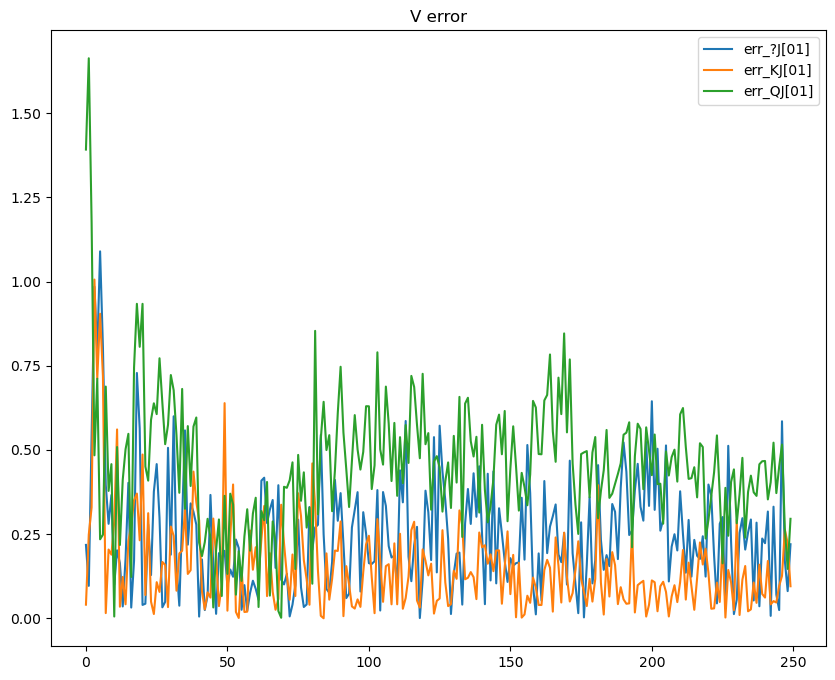

In [65]:
plt.figure(figsize=(10, 8))
plt.plot(df.index, df['err_?J[01]'], label='err_?J[01]')
plt.plot(df.index, df['err_KJ[01]'], label='err_KJ[01]')
plt.plot(df.index, df['err_QJ[01]'], label='err_QJ[01]')
plt.legend()
plt.title('V error')

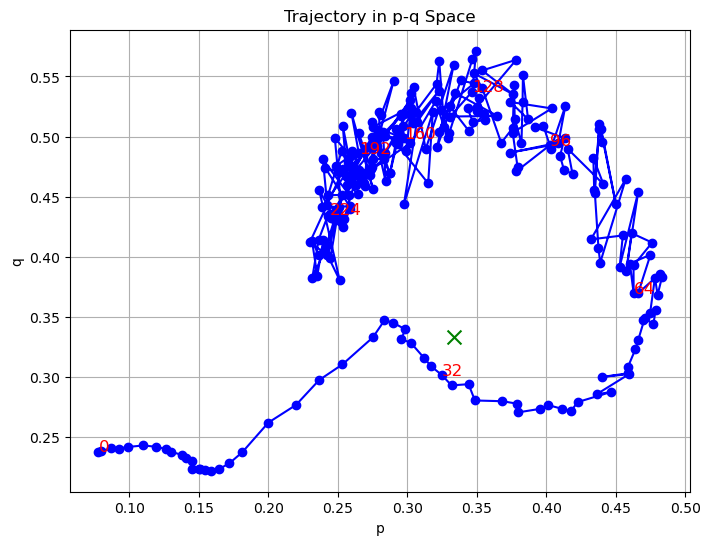

In [66]:
data = df

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 32 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()
